[參考](https://huggingface.co/learn/nlp-course/zh-TW/chapter2/1?fw=pt)

讓我們從一個完整的示例開始，看看在[Chapter 1](https://huggingface.co/course/chapter1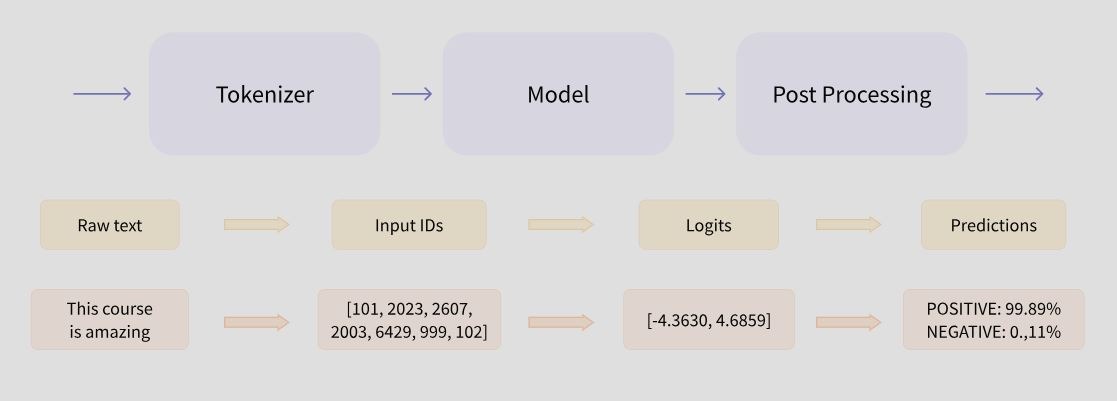)中執行以下代碼時在幕後發生了什麼

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")
classifier(
    [
        "I've been waiting for a HuggingFace course my whole life.",
        "I hate this so much!",
    ]
)

正如我們在[Chapter 1](https://huggingface.co/course/chapter1)中看到的，此管道將三個步驟組合在一起：預處理、通過模型傳遞輸入和後處理：[img](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/full_nlp_pipeline.svg)

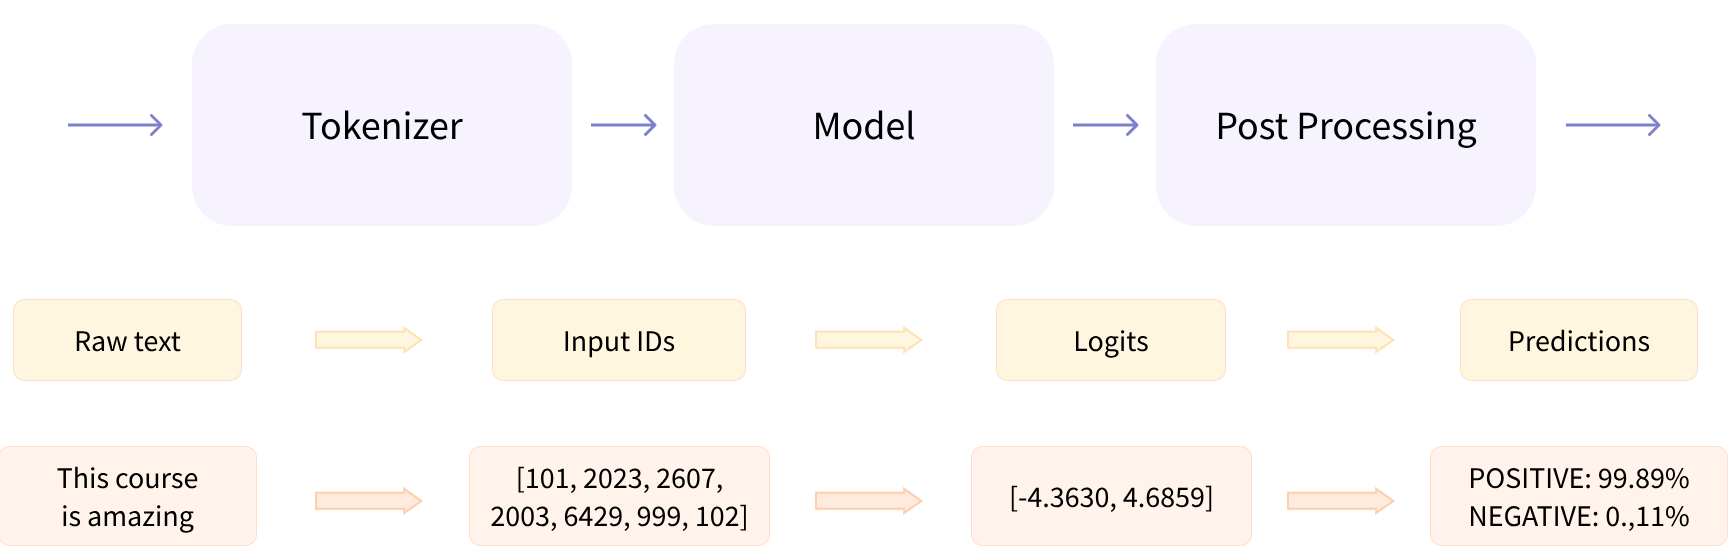

讓我們快速瀏覽一下這些內容。

**使用分詞器進行預處理**

與其他神經網絡一樣，Transformer 模型無法直接處理原始文本， 因此我們管道的第一步是將文本輸入轉換為模型能夠理解的數字。 為此，我們使用tokenizer(標記器)，負責：


*   將輸入拆分為單詞、子單詞或符號（如標點符號），稱為標記(token)
*   將每個標記(token)映射到一個整數
*   添加可能對模型有用的其他輸入


所有這些預處理都需要以與模型預訓練時完全相同的方式完成，因此我們首先需要從[Model Hu](https://huggingface.co/models)b中下載這些信息。為此，我們使用AutoTokenizer類及其from_pretrained()方法。使用我們模型的檢查點名稱，它將自動獲取與模型的標記器相關聯的數據，並對其進行緩存（因此只有在您第一次運行下面的代碼時才會下載）。

因為sentiment-analysis（情緒分析）管道的默認檢查點是distilbert-base-uncased-finetuned-sst-2-english（你可以看到它的模型卡[here](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english))，我們運行以下程序：

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

一旦我們有了標記器，我們就可以直接將我們的句子傳遞給它，然後我們就會得到一本字典，它可以提供給我們的模型！剩下要做的唯一一件事就是將輸入ID列表轉換為張量。

您可以使用🤗 Transformers，而不必擔心哪個 ML 框架被用作後端；它可能是 PyTorch 或 TensorFlow，或 Flax。但是，Transformers型號只接受張量作為輸入。如果這是你第一次聽說張量，你可以把它們想象成NumPy數組。NumPy數組可以是標量（0D）、向量（1D）、矩陣（2D）或具有更多維度。它實際上是張量；其他 ML 框架的張量行為類似，通常與 NumPy 數組一樣易於實例化。

要指定要返回的張量類型（PyTorch、TensorFlow 或 plain NumPy），我們使用return_tensors參數：

In [ ]:
raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
print(inputs)

現在不要擔心填充和截斷；我們稍後會解釋這些。這裡要記住的主要事情是，您可以傳遞一個句子或一組句子，還可以指定要返回的張量類型（如果沒有傳遞類型，您將得到一組列表）。

以上是PyTorch張量的結果：

輸出本身是一個包含兩個鍵的字典，input_ids和attention_mask。input_ids包含兩行整數（每個句子一行），它們是每個句子中標記的唯一標記（token）。我們將在本章後面解釋什麼是attention_mask。

**瀏覽模型**

我們可以像使用標記器一樣下載預訓練模型。🤗 Transformers提供了一個AutoModel類，該類還具有from_pretrained()方法：

In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

在這個代碼片段中，我們下載了之前在管道中使用的相同檢查點（它實際上應該已經被緩存），並用它實例化了一個模型。

這個架構只包含基本轉換器模塊：給定一些輸入，它輸出我們將調用的內容隱藏狀態（hidden states），亦稱特徵（features）。對於每個模型輸入，我們將檢索一個高維向量，表示Transformer模型對該輸入的上下文理解。

如果這不合理，不要擔心。我們以後再解釋。

雖然這些隱藏狀態本身可能很有用，但它們通常是模型另一部分（稱為頭部(head)）的輸入。 在Chapter 1中，可以使用相同的體系結構執行不同的任務，但這些任務中的每個任務都有一個與之關聯的不同頭。

**高維向量？**

Transformers 模塊的向量輸出通常較大。它通常有三個維度：


*   Batch size: 一次處理的序列數（在我們的示例中為2）。
*   Sequence length: 序列的數值表示的長度（在我們的示例中為16）。
*   Hidden size: 每個模型輸入的向量維度。


由於最後一個值，它被稱為「高維」。隱藏的大小可能非常大（768通常用於較小的型號，而在較大的型號中，這可能達到3072或更大）。

如果我們將預處理的輸入輸入到模型中，我們可以看到這一點：

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

注意🤗 Transformers 模型的輸出與namedtuple或詞典相似。您可以通過屬性（就像我們所做的那樣）或鍵（輸出["last_hidden_state"]）訪問元素，甚至可以通過索引訪問元素，前提是您確切知道要查找的內容在哪裡（outputs[0]）。

**模型頭：數字的意義**

模型頭將隱藏狀態的高維向量作為輸入，並將其投影到不同的維度。它們通常由一個或幾個線性層組成：[img](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/transformer_and_head.svg)

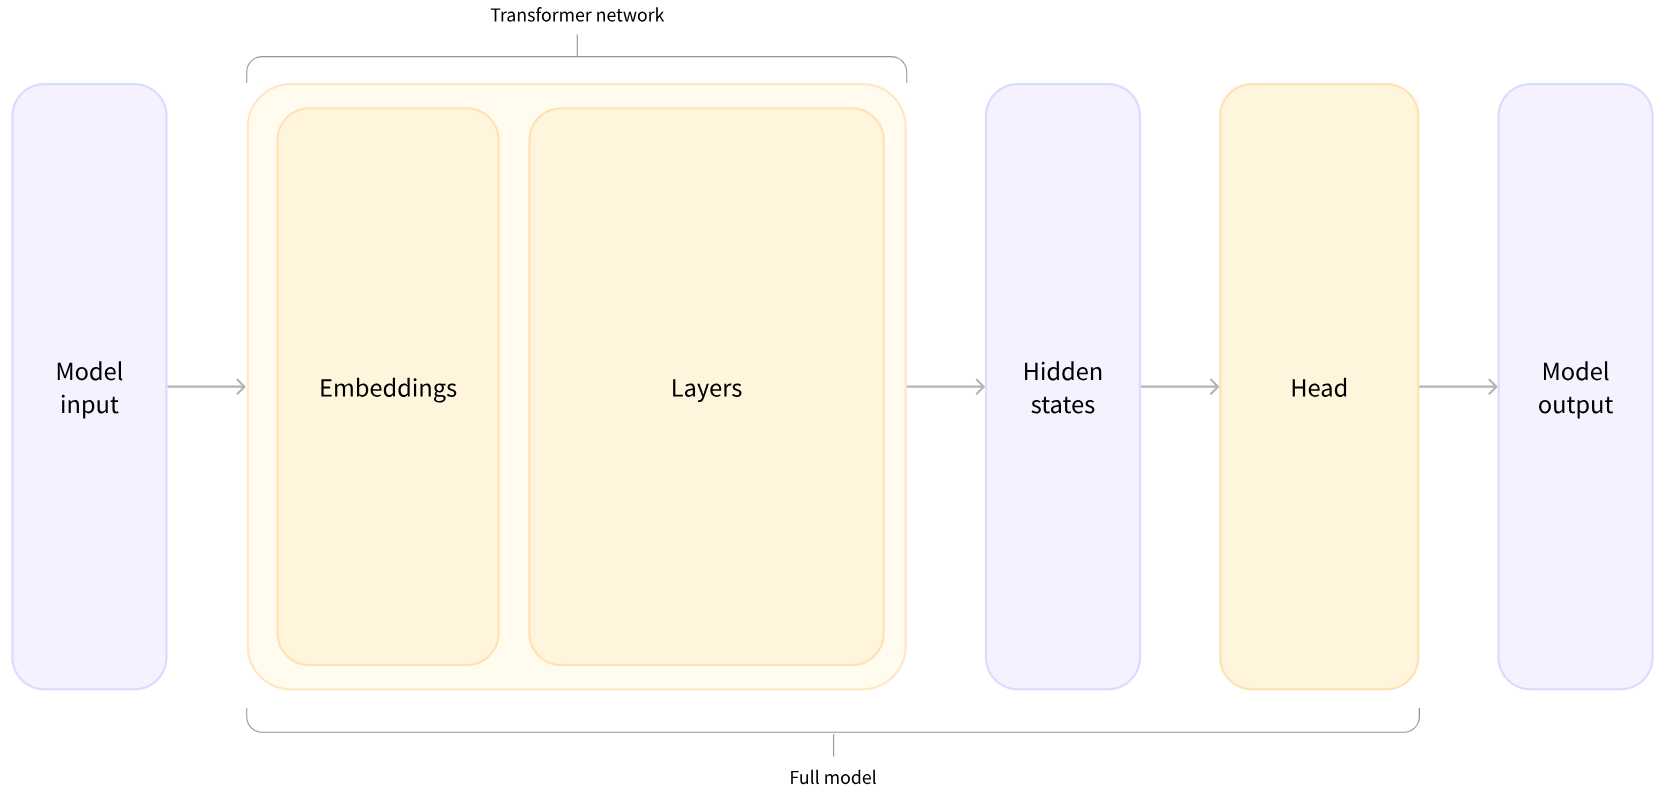

Transformers 模型的輸出直接發送到模型頭進行處理。

在此圖中，模型由其嵌入層和後續層表示。嵌入層將標記化輸入中的每個輸入ID轉換為表示關聯標記(token)的向量。後續層使用注意機制操縱這些向量，以生成句子的最終表示。

🤗 Transformers中有許多不同的體系結構，每種體系結構都是圍繞處理特定任務而設計的。以下是一個非詳盡的列表：

*   Model (retrieve the hidden states)
*   ForCausalLM
*   ForMaskedLM
*   ForMultipleChoice
*   ForQuestionAnswering
*   ForSequenceClassification
*   ForTokenClassification
*   以及其他 🤗

對於我們的示例，我們需要一個帶有序列分類頭的模型（能夠將句子分類為肯定或否定）。因此，我們實際上不會使用AutoModel類，而是使用AutoModelForSequenceClassification：

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

現在，如果我們觀察輸入的形狀，維度將低得多：模型頭將我們之前看到的高維向量作為輸入，並輸出包含兩個值的向量（每個標籤一個）：

In [ ]:
print(outputs.logits.shape)

因為我們只有兩個句子和兩個標籤，所以我們從模型中得到的結果是2 x 2的形狀。

對輸出進行後處理
我們從模型中得到的輸出值本身並不一定有意義。我們來看看,

In [ ]:
print(outputs.logits)

我們的模型預測第一句為[-1.5607, 1.6123]，第二句為[ 4.1692, -3.3464]。這些不是概率，而是logits，即模型最後一層輸出的原始非標準化分數。要轉換為概率，它們需要經過[SoftMax](https://en.wikipedia.org/wiki/Softmax_function)層（所有🤗Transformers模型輸出logits，因為用於訓練的損耗函數通常會將最後的激活函數（如SoftMax）與實際損耗函數（如交叉熵）融合）：

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

現在我們可以看到，模型預測第一句為[0.0402, 0.9598]，第二句為[0.9995, 0.0005]。這些是可識別的概率分數。

為了獲得每個位置對應的標籤，我們可以檢查模型配置的id2label屬性（下一節將對此進行詳細介紹）：

In [ ]:
model.config.id2label

現在我們可以得出結論，該模型預測了以下幾點：

*   第一句：否定：0.0402，肯定：0.9598
*   第二句：否定：0.9995，肯定：0.0005
我們已經成功地複製了管道的三個步驟：使用標記化器進行預處理、通過模型傳遞輸入以及後處理！現在，讓我們花一些時間深入瞭解這些步驟中的每一步。

===========

**模型**

在本節中，我們將更詳細地瞭解如何創建和使用模型。我們將使用 AutoModel類，當您希望從檢查點實例化任何模型時，這非常方便。

這個AutoModel類及其所有相關項實際上是對庫中各種可用模型的簡單包裝。它是一個聰明的包裝器，因為它可以自動猜測檢查點的適當模型體系結構，然後用該體系結構實例化模型。

但是，如果您知道要使用的模型類型，則可以使用直接定義其體系結構的類。讓我們看看這是如何與BERT模型一起工作的。


**創建轉換器**

初始化BERT模型需要做的第一件事是加載配置對象：

In [ ]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)

配置包含許多用於構建模型的屬性：

In [ ]:
print(config)

雖然您還沒有看到所有這些屬性都做了什麼，但您應該認識到其中的一些屬性：hiddensize屬性定義了hidden狀態向量的大小，num_hidden_layers定義了Transformer模型的層數。

**不同的加載方式**

從默認配置創建模型會使用隨機值對其進行初始化：

In [ ]:
from transformers import BertConfig, BertModel

config = BertConfig()
model = BertModel(config)

# Model is randomly initialized!

該模型可以在這種狀態下使用，但會輸出胡言亂語；首先需要對其進行訓練。我們可以根據手頭的任務從頭開始訓練模型，但正如您在 [Chapter 1](https://huggingface.co/course/chapter1) ，這將需要很長的時間和大量的數據，並將產生不可忽視的環境影響。為了避免不必要的重複工作，必須能夠共享和重用已經訓練過的模型。

加載已經訓練過的Transformers模型很簡單-我們可以使用from_pretrained() 方法：

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

正如您之前看到的，我們可以用等效的AutoModel類替換Bert模型。從現在開始，我們將這樣做，因為這會產生檢查點不可知的代碼；如果您的代碼適用於一個檢查點，那麼它應該與另一個檢查點無縫地工作。即使體系結構不同，這也適用，只要檢查點是針對類似任務（例如，情緒分析任務）訓練的。

在上面的代碼示例中，我們沒有使用BertConfig

，而是通過Bert base cased標識符加載了一個預訓練模型。這是一個模型檢查點，由BERT的作者自己訓練；您可以在 [model card](https://huggingface.co/bert-base-cased)中找到更多細節.

該模型現在使用檢查點的所有權重進行初始化。它可以直接用於對訓練過的任務進行推理，也可以對新任務進行微調。通過預先訓練重量而不是從頭開始的訓練，我們可以很快取得好的效果。

權重已下載並緩存在緩存文件夾中（因此將來對from_pretrained()方法的調用將不會重新下載它們）默認為 ~/.cache/huggingface/transformers . 您可以通過設置 HF_HOME 環境變量來自定義緩存文件夾。

用於加載模型的標識符可以是模型中心Hub上任何模型的標識符，只要它與BERT體系結構兼容。可以找到可用的BERT檢查點的完整列表 [here](https://huggingface.co/models?filter=bert) .

保存模型
保存模型和加載模型一樣簡單—我們使用 save_pretrained() 方法，類似於 from_pretrained() 方法：

In [ ]:
#model.save_pretrained("directory_on_my_computer")

這會將兩個文件保存到磁盤：

In [ ]:
#ls directory_on_my_computer

可以直接看[這裏](https://huggingface.co/bert-base-cased/blob/main/config.json)

如果你看一下 config.json 文件，您將識別構建模型體系結構所需的屬性。該文件還包含一些元數據，例如檢查點的來源以及上次保存檢查點時使用的🤗 Transformers版本。

這個 pytorch_model.bin 文件就是眾所周知的state dictionary; 它包含模型的所有權重。這兩個文件齊頭並進；配置是瞭解模型體系結構所必需的，而模型權重是模型的參數。

使用Transformers模型進行推理
既然您知道了如何加載和保存模型，那麼讓我們嘗試使用它進行一些預測。Transformer模型只能處理數字——分詞器生成的數字。但在我們討論標記化器之前，讓我們先探討模型接受哪些輸入。

標記化器可以將輸入轉換為適當的框架張量，但為了幫助您瞭解發生了什麼，我們將快速瞭解在將輸入發送到模型之前必須做什麼。

假設我們有幾個序列：

In [ ]:
sequences = ["Hello!", "Cool.", "Nice!"]

分詞器將這些轉換為詞彙表索引，通常稱為 input IDs . 每個序列現在都是一個數字列表！結果是：


In [ ]:
encoded_sequences = [
    [101, 7592, 999, 102],
    [101, 4658, 1012, 102],
    [101, 3835, 999, 102],
]

這是一個編碼序列列表：一個列表列表。張量只接受矩形（想想矩陣）。此“數組”已為矩形，因此將其轉換為張量很容易：

In [ ]:
import torch

model_inputs = torch.tensor(encoded_sequences)

**使用張量作為模型的輸入**

在模型中使用張量非常簡單-我們只需將輸入稱為模型：

In [ ]:
output = model(model_inputs)

雖然模型接受許多不同的參數，但只需要 input IDs。我們稍後將解釋其他參數的作用以及何時需要它們，但首先我們需要更仔細地瞭解 Transformer模型可以理解的輸入的標記



===================休息一下======================


**標記器（Tokenizer）**

標記器(Tokenizer)是 NLP 管道的核心組件之一。它們有一個目的：將文本轉換為模型可以處理的數據。模型只能處理數字，因此標記器(Tokenizer)需要將我們的文本輸入轉換為數字數據。在本節中，我們將確切地探討標記化管道中發生的事情。

在 NLP 任務中，通常處理的數據是原始文本。這是此類文本的示例

"Jim Henson was a puppeteer"

但是，模型只能處理數字，因此我們需要找到一種將原始文本轉換為數字的方法。這就是標記器（tokenizer）所做的，並且有很多方法可以解決這個問題。目標是找到最有意義的表示——即對模型最有意義的表示——並且如果可能的話，找到最小的表示。

讓我們看一下標記化算法的一些示例，並嘗試回答您可能對標記化提出的一些問題。

**基於詞的(Word-based)**

想到的第一種標記器是基於詞的(word-based).它通常很容易設置和使用，只需幾條規則，並且通常會產生不錯的結果。例如，在下圖中，目標是將原始文本拆分為單詞併為每個單詞找到一個數字表示：[img](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/word_based_tokenization.svg)

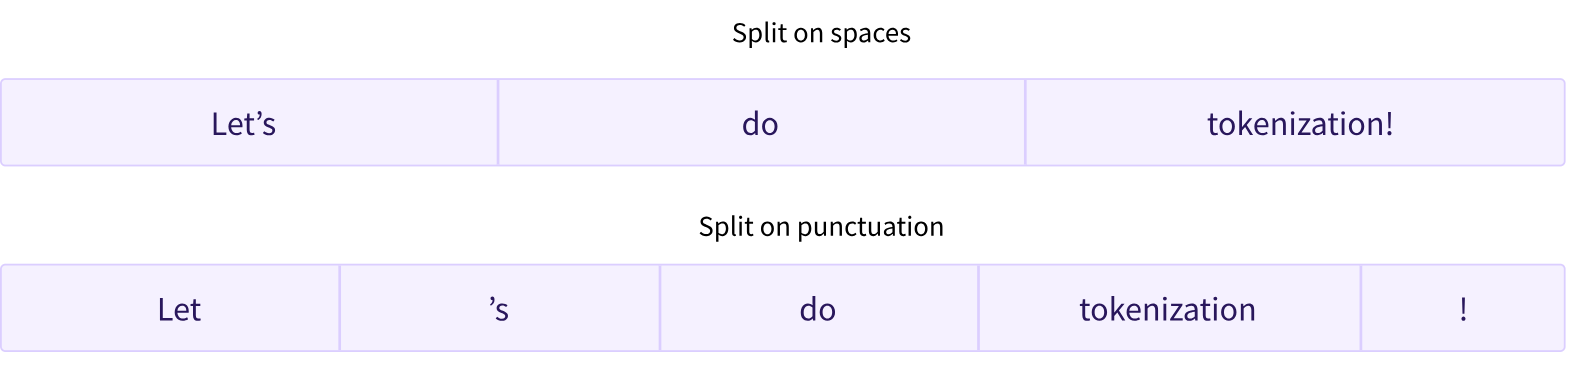

有多種方法可以拆分文本。例如，我們可以通過應用Python的split()函數，使用空格將文本標記為單詞：

In [ ]:
tokenized_text = "Jim Henson was a puppeteer".split()
print(tokenized_text)

還有一些單詞標記器的變體，它們具有額外的標點符號規則。使用這種標記器，我們最終可以得到一些非常大的“詞彙表”，其中詞彙表由我們在語料庫中擁有的獨立標記的總數定義。

每個單詞都分配了一個 ID，從 0 開始一直到詞彙表的大小。該模型使用這些 ID 來識別每個單詞。

如果我們想用基於單詞的標記器(tokenizer)完全覆蓋一種語言，我們需要為語言中的每個單詞都有一個標識符，這將生成大量的標記。例如，英語中有超過 500,000 個單詞，因此要構建從每個單詞到輸入 ID 的映射，我們需要跟蹤這麼多 ID。此外，像“dog”這樣的詞與“dogs”這樣的詞的表示方式不同，模型最初無法知道“dog”和“dogs”是相似的：它會將這兩個詞識別為不相關。這同樣適用於其他相似的詞，例如“run”和“running”，模型最初不會認為它們是相似的。

最後，我們需要一個自定義標記(token)來表示不在我們詞彙表中的單詞。這被稱為“未知”標記(token)，通常表示為“[UNK]”或”“。如果你看到標記器產生了很多這樣的標記，這通常是一個不好的跡象，因為它無法檢索到一個詞的合理表示，並且你會在這個過程中丟失信息。製作詞彙表時的目標是以這樣一種方式進行，即標記器將盡可能少的單詞標記為未知標記。

減少未知標記數量的一種方法是使用更深一層的標記器(tokenizer)，即基於字符的(character-based)標記器(tokenizer)。

**基於字符(Character-based)**

基於字符的標記器(tokenizer)將文本拆分為字符，而不是單詞。這有兩個主要好處：


*   詞彙量要小得多。
*   詞彙外（未知）標記(token)要少得多，因為每個單詞都可以從字符構建。


但是這裡也出現了一些關於空格和標點符號的問題：[img](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/character_based_tokenization.svg)

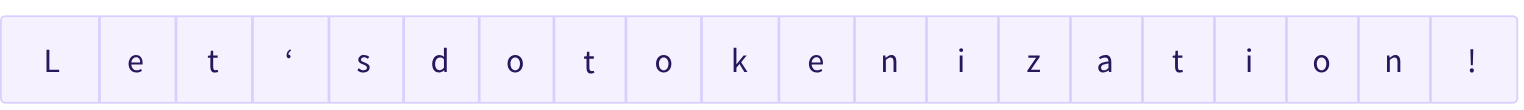

這種方法也不是完美的。由於現在表示是基於字符而不是單詞，因此人們可能會爭辯說，從直覺上講，它的意義不大：每個字符本身並沒有多大意義，而單詞就是這種情況。然而，這又因語言而異；例如，在中文中，每個字符比拉丁語言中的字符包含更多的信息。

另一件要考慮的事情是，我們的模型最終會處理大量的詞符(token)：雖然使用基於單詞的標記器(tokenizer)，單詞只會是單個標記，但當轉換為字符時，它很容易變成 10 個或更多的詞符(token)。

為了兩全其美，我們可以使用結合這兩種方法的第三種技術：子詞標記化(subword tokenization)。

**子詞標記化**

子詞分詞算法依賴於這樣一個原則，即不應將常用詞拆分為更小的子詞，而應將稀有詞分解為有意義的子詞。

例如，“annoyingly”可能被認為是一個罕見的詞，可以分解為“annoying”和“ly”。這兩者都可能作為獨立的子詞出現得更頻繁，同時“annoyingly”的含義由“annoying”和“ly”的複合含義保持。

這是一個示例，展示了子詞標記化算法如何標記序列“Let’s do tokenization!”：
[img](https://huggingface.co/datasets/huggingface-course/documentation-images/resolve/main/en/chapter2/bpe_subword.svg)

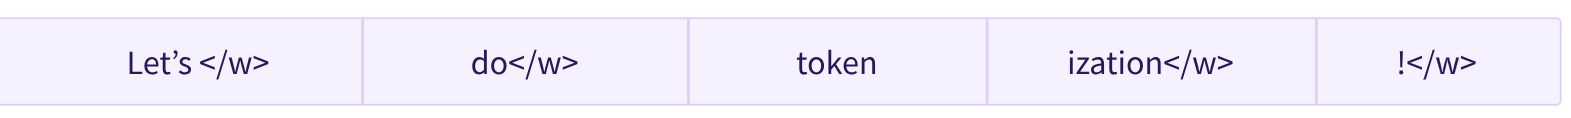

這些子詞最終提供了很多語義含義：例如，在上面的示例中，“tokenization”被拆分為“token”和“ization”，這兩個具有語義意義同時節省空間的詞符(token)（只需要兩個標記(token)代表一個長詞）。這使我們能夠對較小的詞彙表進行相對較好的覆蓋，並且幾乎沒有未知的標記

這種方法在土耳其語等粘著型語言(agglutinative languages)中特別有用，您可以通過將子詞串在一起來形成（幾乎）任意長的複雜詞。

**還有更多！**

不出所料，還有更多的技術。僅舉幾例：

*   Byte-level BPE, 用於 GPT-2
*   WordPiece, 用於 BERT
*   SentencePiece or Unigram, 用於多個多語言模型
您現在應該對標記器(tokenizers)的工作原理有足夠的瞭解，以便開始使用 API。

加載和保存
加載和保存標記器(tokenizer)就像使用模型一樣簡單。實際上，它基於相同的兩種方法： from_pretrained() 和 save_pretrained() 。這些方法將加載或保存標記器(tokenizer)使用的算法（有點像建築學(architecture)的模型）以及它的詞彙（有點像權重(weights)模型）。

加載使用與 BERT 相同的檢查點訓練的 BERT 標記器(tokenizer)與加載模型的方式相同，除了我們使用 BertTokenizer 類：

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

如同 AutoModel，AutoTokenizer 類將根據檢查點名稱在庫中獲取正確的標記器(tokenizer)類，並且可以直接與任何檢查點一起使用：

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

我們現在可以使用標記器(tokenizer)，如上一節所示：

In [ ]:
tokenizer("Using a Transformer network is simple")

保存標記器(tokenizer)與保存模型相同:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/directory_on_my_computer")

我們在[Chapter 3](https://huggingface.co/Couse/chapter3)中將更多地談論token_type_ids，稍後我們將解釋 attention_mask 鍵。首先，讓我們看看 input_ids 如何生成。為此，我們需要查看標記器(tokenizer)的中間方法。

**編碼**

將文本翻譯成數字被稱為編碼(encoding).編碼分兩步完成：標記化，然後轉換為輸入 ID。

正如我們所見，第一步是將文本拆分為單詞（或單詞的一部分、標點符號等），通常稱為標記(token)。有多個規則可以管理該過程，這就是為什麼我們需要使用模型名稱來實例化標記器(tokenizer)，以確保我們使用模型預訓練時使用的相同規則。

第二步是將這些標記轉換為數字，這樣我們就可以用它們構建一個張量並將它們提供給模型。為此，標記器(tokenizer)有一個詞彙(vocabulary)，這是我們在實例化它時下載的部分 from_pretrained() 方法。同樣，我們需要使用模型預訓練時使用的相同詞彙。

為了更好地理解這兩個步驟，我們將分別探討它們。請注意，我們將使用一些單獨執行部分標記化管道的方法來向您展示這些步驟的中間結果，但實際上，您應該直接在您的輸入上調用標記器(tokenizer)（如第 2 部分所示）。

**標記化**

標記化過程由標記器(tokenizer)的tokenize() 方法實現：
此方法的輸出是一個字符串列表或標記(token)：

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

sequence = "Using a Transformer network is simple"
tokens = tokenizer.tokenize(sequence)

print(tokens)

這個標記器(tokenizer)是一個子詞標記器(tokenizer)：它對詞進行拆分，直到獲得可以用其詞彙表表示的標記(token)。transformer 就是這種情況，它分為兩個標記：transform 和 ##er。

**從詞符(token)到輸入 ID**

輸入 ID 的轉換由標記器(tokenizer)的`convert_tokens_to_ids()`方法實現：

In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

這些輸出一旦轉換為適當的框架張量，就可以用作模型的輸入，如本章前面所見。

**解碼**

解碼(Decoding) 正好相反：從詞彙索引中，我們想要得到一個字符串。這可以通過 decode() 方法實現，如下：

In [ ]:
decoded_string = tokenizer.decode([7993, 170, 11303, 1200, 2443, 1110, 3014])
print(decoded_string)

請注意， decode 方法不僅將索引轉換回標記(token)，還將屬於相同單詞的標記(token)組合在一起以生成可讀的句子。當我們使用預測新文本的模型（根據提示生成的文本，或序列到序列問題（如翻譯或摘要））時，這種行為將非常有用。

到現在為止，您應該瞭解標記器(tokenizer)可以處理的原子操作：標記化、轉換為 ID 以及將 ID 轉換回字符串。然而，我們只是刮到了冰山一角。在下一節中，我們將採用我們的方法來克服它的限制，並看看如何克服它們。

================休息一下==================


**處理多個序列**
在上一節中，我們探討了最簡單的用例：對一個小長度的序列進行推理。然而，一些問題已經出現：

*   我們如何處理多個序列？
*   我們如何處理多個序列不同長度?
*   詞彙索引是讓模型正常工作的唯一輸入嗎？
*   是否存在序列太長的問題？
讓我們看看這些問題會帶來什麼樣的問題，以及如何使用🤗 Transformers API解決它們

**模型需要一批輸入**

在上一個練習中，您看到了序列如何轉換為數字列表。讓我們將此數字列表轉換為張量，並將其發送到模型：

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

哦不！為什麼失敗了？我們遵循了第2節中管道的步驟。

問題是我們向模型發送了一個序列，而 🤗Transformers 模型默認情況下需要多個句子。在這裡，當我們將分詞器應用於一個應用程序時，我們嘗試在幕後完成分詞器所做的一切，但如果仔細觀察，您會發現它不僅將輸入ID列表轉換為張量，還在其頂部添加了一個維度：

In [ ]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

讓我們重試並添加一個新維度：

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

Batching 是一次通過模型發送多個句子的行為。如果你只有一句話，你可以用一個序列構建一個批次：

In [ ]:
batched_ids = [ids, ids]

這是一批兩個相同的序列！

批處理允許模型在輸入多個句子時工作。使用多個序列就像使用單個序列構建批一樣簡單。不過，還有第二個問題。當你試圖將兩個（或更多）句子組合在一起時，它們的長度可能不同。如果您以前使用過張量，那麼您知道它們必須是矩形，因此無法將輸入ID列表直接轉換為張量。為了解決這個問題，我們通常填充輸入。

**填充輸入**

以下列表不能轉換為張量：

In [ ]:
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

為了解決這個問題，我們將使用填充使張量具有矩形。Padding通過在值較少的句子中添加一個名為Padding token的特殊單詞來確保我們所有的句子長度相同。例如，如果你有10個包含10個單詞的句子和1個包含20個單詞的句子，填充將確保所有句子都包含20個單詞。在我們的示例中，生成的張量如下所示：

In [ ]:
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

可以在tokenizer.pad_token_id中找到填充令牌ID. 讓我們使用它，將我們的兩句話分別發送到模型中，並分批發送到一起：

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

我們批處理預測中的logits有點問題：第二行應該與第二句的logits相同，但我們得到了完全不同的值！

這是因為Transformer模型的關鍵特性是關注層，它將每個標記上下文化。這些將考慮填充標記，因為它們涉及序列中的所有標記。為了在通過模型傳遞不同長度的單個句子時，或者在傳遞一批應用了相同句子和填充的句子時獲得相同的結果，我們需要告訴這些注意層忽略填充標記。這是通過使用 attention mask來實現的。

**注意力遮罩（Attention masks）**

Attention masks 是與輸入 ID 張量形狀完全相同的張量，用0和1填充：1s表示應注意相應的標記，0s表示不應注意相應的標記（即，模型的注意力層應忽略它們）。

讓我們用 attention mask 完成上一個示例：

In [ ]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

現在我們得到了該批中第二個句子的相同登錄。

請注意，第二個序列的最後一個值是一個填充ID，它在attention mask中是一個0值。

**長序列**

對於Transformers模型，我們可以通過模型的序列長度是有限的。大多數模型處理多達512或1024個令牌的序列，當要求處理更長的序列時，會崩潰。此問題有兩種解決方案：

使用支持的序列長度較長的模型。
截斷序列。
模型有不同的支持序列長度，有些模型專門處理很長的序列。 Longformer 這是一個例子，另一個是 LED . 如果您正在處理一項需要很長序列的任務，我們建議您查看這些模型。

否則，我們建議您通過指定max_sequence_length參數：

In [ ]:
max_sequence_length = 89
sequence = sequence[:max_sequence_length]
sequence

=========================休息一下===============================

**把它們放在一起**


在最後幾節中，我們一直在盡最大努力手工完成大部分工作。我們探討了標記化器的工作原理，並研究了標記化、到輸入ID的轉換、填充、截斷和注意掩碼。

然而，正如我們在第2節中所看到的，🤗 Transformers API可以通過一個高級函數為我們處理所有這些，我們將在這裡深入討論。當你直接在句子上調用標記器時，你會得到準備通過模型傳遞的輸入

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)

這裡，model_inputs 變量包含模型良好運行所需的一切。對於DistilBERT，它包括輸入 ID和注意力掩碼(attention mask)。其他接受額外輸入的模型也會有標記器對象的輸出。

正如我們將在下面的一些示例中看到的，這種方法非常強大。首先，它可以標記單個序列：

In [ ]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
model_inputs

它還一次處理多個序列，並且API沒有任何變化：

In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences)
model_inputs

它可以根據幾個目標進行填充：

In [ ]:
# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)
model_inputs

它還可以截斷序列:

In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)
model_inputs

標記器對象可以處理到特定框架張量的轉換，然後可以直接發送到模型。例如，在下面的代碼示例中，我們提示標記器從不同的框架返回張量——"pt"返回Py Torch張量，"tf"返回TensorFlow張量，"np"返回NumPy數組：

In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Returns PyTorch tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

# Returns TensorFlow tensors
model_inputs = tokenizer(sequences, padding=True, return_tensors="tf")

# Returns NumPy arrays
model_inputs = tokenizer(sequences, padding=True, return_tensors="np")
model_inputs

**特殊詞符(token)**

如果我們看一下標記器返回的輸入 ID，我們會發現它們與之前的略有不同：

In [ ]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

一個在開始時添加了一個標記(token) ID，一個在結束時添加了一個標記(token) ID。讓我們解碼上面的兩個ID序列，看看這是怎麼回事：

In [ ]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

標記器在開頭添加了特殊單詞[CLS]，在結尾添加了特殊單詞[SEP]。這是因為模型是用這些數據預訓練的，所以為了得到相同的推理結果，我們還需要添加它們。請注意，有些模型不添加特殊單詞，或者添加不同的單詞；模型也可能只在開頭或結尾添加這些特殊單詞。在任何情況下，標記器都知道需要哪些詞符，並將為您處理這些詞符。

**結束：從標記器到模型**

現在我們已經看到了標記器對象在應用於文本時使用的所有單獨步驟，讓我們最後一次看看它如何處理多個序列（填充！），非常長的序列（截斷！），以及多種類型的張量及其主要API：

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)

In [ ]:
output

基本用法完成！

很好地完成了到這裡的課程！總而言之，在本章中，您可以：

學習了Transformers模型的基本構造塊。
瞭解了標記化管道的組成。
瞭解瞭如何在實踐中使用Transformers模型。
學習瞭如何利用分詞器將文本轉換為模型可以理解的張量。
將分詞器和模型一起設置，以從文本到預測。
瞭解了inputs IDs的侷限性，並瞭解了attention mask。
使用多功能和可配置的分詞器方法。
從現在起，您應該能夠自由瀏覽🤗 Transformers文檔：詞彙聽起來很熟悉，並且您已經看到了大部分時間將使用的方法。